In [5]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from utils import create_directory
from plot import plot_learning
import matplotlib.pyplot as plt

In [6]:
data_dir = create_directory(directory_name='finetune10')

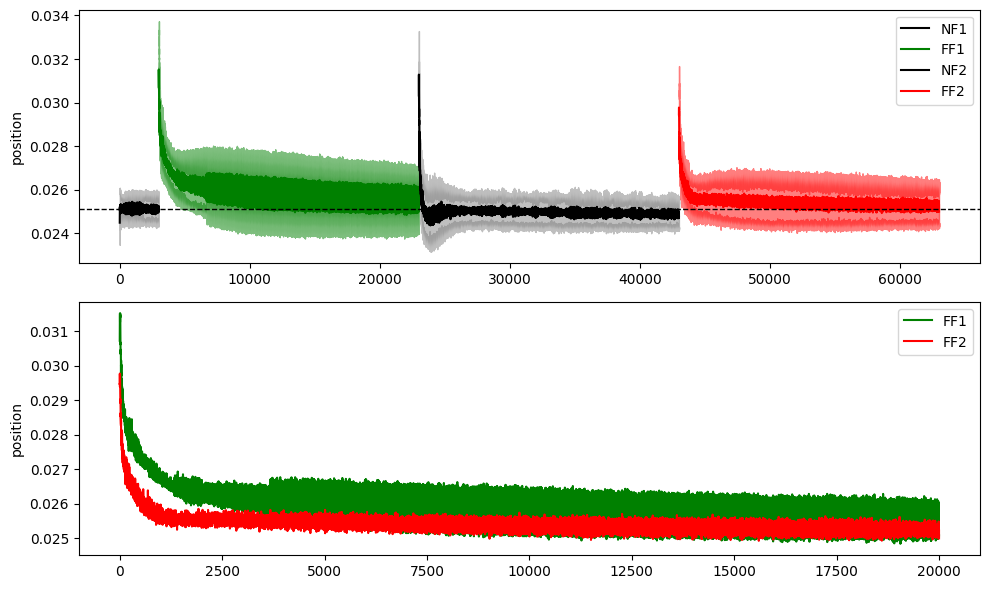

In [7]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='position',figsize=(10,6))
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,'learning_curve_al.png'),dpi=300)

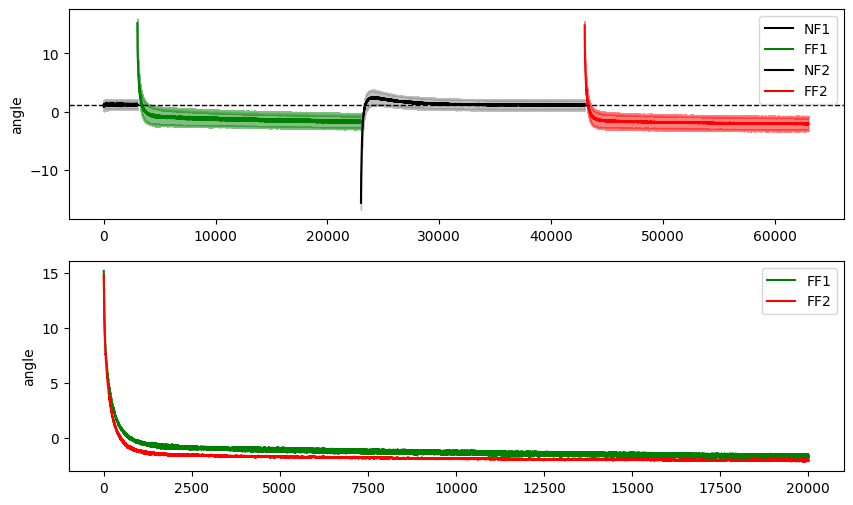

In [8]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='angle',figsize=(10,6))

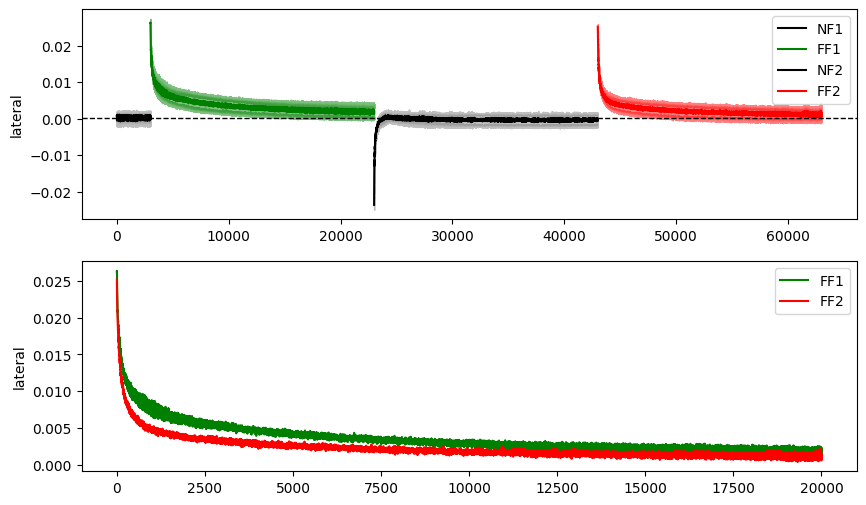

In [9]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='lateral',figsize=(10,6))